In [18]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt

In [112]:
def avg_cluster_size(p,L, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    counts = np.zeros(L**2+1,dtype=np.int64)
    for _ in range(repititions):
        G = rx.generators.grid_graph(L,L)
        for idx in G.edge_indices():
            if p < rand():
                G.remove_edge_from_index(idx)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=L**2+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(L**2+1))    
    return (bins**2 @ counts) / (bins@counts)

def percolation_strength(p,L,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    for _ in range(repititions):
        G = rx.generators.grid_graph(L,L)
        for idx in G.edge_indices():
            if p < rand():
                G.remove_edge_from_index(idx)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / L**2
    return P/repititions

def cluster_size_and_strength(p,L,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    counts = np.zeros(L**2+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = rx.generators.grid_graph(L,L)
        for idx in G.edge_indices():
            if p < rand():
                G.remove_edge_from_index(idx)
        distro = [len(comp) for comp in rx.connected_components(G)]
        largest_local = np.max(distro)
        P += largest_local / L**2
        temp_counts = np.bincount([len(comp) for comp in rx.connected_components(G)],minlength=L**2+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(L**2+1))    
    return (bins**2 @ counts) / (bins@counts), P

In [123]:
pvals = np.arange(.3,.7,.01)

density = {}
strength = {}
Lvals = [50,60,70,80,90,100]

for L in Lvals:
    density[L] = [avg_cluster_size(p,L,repititions=250) for p in pvals]
    strength[L] = [percolation_strength(p,L,repititions=250) for p in pvals]

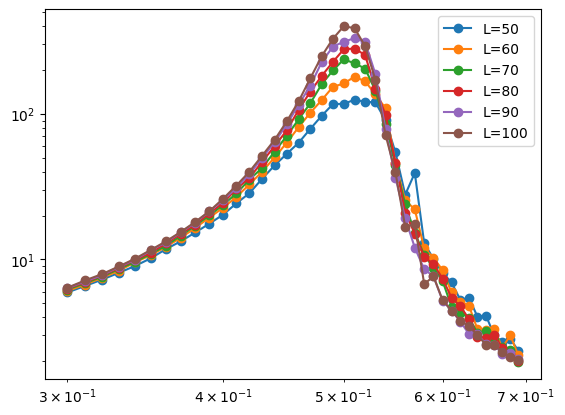

In [127]:
for L in Lvals:
    plt.loglog(pvals,density[L],label=f"L={L}",marker='o')
plt.legend()
plt.show()

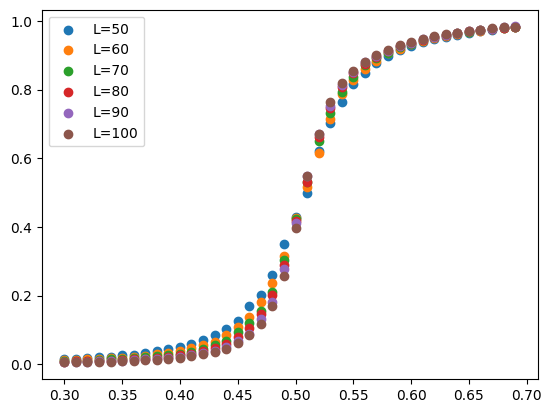

In [125]:
for L in Lvals:
    plt.scatter(pvals,strength[L],label=f"L={L}")
plt.legend()
plt.show()